In [ ]:
###############################
# Muhammad Bello
# SID:2058306
# Edit Date: 05/04/2022
# GitHub Repo:
# https://github.com/AYSIK0/Kaggle_Intel-MobileODT-Cervical-Cancer-Screening
###############################


In [1]:
#For Data Processing
import pandas as pd
import numpy as np

# For ML Models
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns


2023-04-09 03:44:49.779865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Function to create train set from the given data path.

def create_dataset(data_path, img_size=(256, 256), batch_size=32, shuffle=True):
    """
    Function to create a dataset from the given data path.
    """
    dataset = tf.keras.utils.image_dataset_from_directory(data_path,                                
        labels = 'inferred',
        label_mode = 'categorical',
        class_names = None,
        batch_size = batch_size,
        image_size = img_size,
        shuffle = shuffle,
        interpolation = 'bilinear',
    )
    return dataset

def create_train_val_ds(data_path, img_size=(256, 256), batch_size=32, shuffle=True, val_split=0.2, seed=2323):
    """
    Function to create dataset/s from the given data path.
    """
    
    train_set = tf.keras.utils.image_dataset_from_directory(data_path,                                
        labels = 'inferred',
        label_mode = 'categorical',
        batch_size = batch_size,
        seed = seed,
        validation_split = val_split,
        subset = "training",
        image_size = img_size,
        shuffle = shuffle,
        interpolation = 'bilinear',
    )
    val_set = tf.keras.utils.image_dataset_from_directory(data_path,                                
        labels = 'inferred',
        label_mode = 'categorical',
        batch_size = batch_size,
        seed = seed,
        validation_split = val_split,
        subset = "validation",
        image_size = img_size,
        shuffle = shuffle,
        interpolation = 'bilinear',
    )
    return (train_set, val_set)

# Function to create a dataframe with the count of each label in the dataset.

def label_count_df(dataset):
    """
    Function to create a dataframe with the count of each label in the dataset.
    """
    labels = []
    for image, label in dataset:
        for i in label.numpy():
          labels.append(i.argmax())
    labels = pd.DataFrame(labels, columns=['label'])
    labels["label"] = labels["label"].map({0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"})
    return labels

# Functin to plot metrics of the model.

def plot_metric(m_history, metric: str, val=True):
  """
  Function to Plots the model metrics.
  """
  train_metric = m_history.history[metric]
  if val:
    val_metric = m_history.history["val_"+metric]

  num_epochs = range(1, len(train_metric)+1)
  plt.plot(num_epochs, train_metric)
  if val:
    plt.plot(num_epochs, val_metric)
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  if val:
    plt.title(f"Train and Validation: {metric}")
    plt.legend(["Train", "Validation"], loc="best")
  else:
    plt.title(f"Train : {metric}")
    plt.legend(["Train"], loc="best")
  
  plt.show()


In [3]:
# 

CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]
BATCH_SIZE = 16

# Specify the path to the dataset.
train_path = "MRISCANS/Training/"

# specify the path to the test dataset.
test_path = "MRISCANS/Testing/"

In [4]:

# Create the train dataset and validation dataset.
train_dataset, valid_dataset = create_train_val_ds(train_path, img_size=(256, 256), batch_size=BATCH_SIZE, shuffle=True, val_split=0.2, seed=2323)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


2023-04-09 03:45:45.362919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [5]:
# Dataset labels.
train_dataset.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
# Visualize the dataset.
train_labels_df = label_count_df(train_dataset)

In [7]:
# Plot the count of each label in the dataset.

train_labels_df.head()

,label
0,notumor
1,pituitary
2,pituitary
3,glioma
4,meningioma


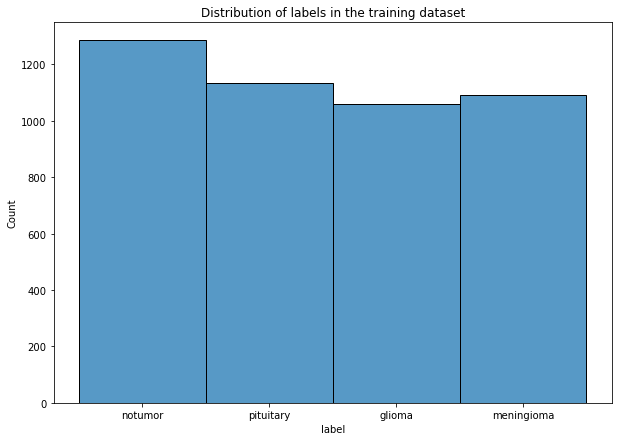

In [9]:
# Plot the distribution of labels in the dataset.

plt.figure(figsize=(10, 7))
sns.histplot(train_labels_df.label).set_title("Distribution of labels in the training dataset");

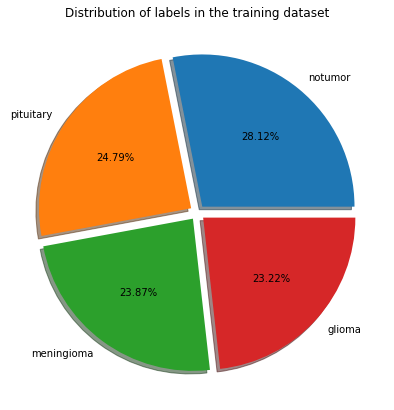

In [10]:
# Pie Chart for the distribution of labels in the training dataset.
plt.figure(figsize=(10, 7))
plt.title("Distribution of labels in the training dataset")
plt.pie(train_labels_df.label.value_counts(), 
        labels=train_labels_df.label.value_counts().index, 
        autopct='%1.2f%%', 
        shadow=True, 
        explode=[0.05, 0.05, 0.05, 0.05])
plt.show()

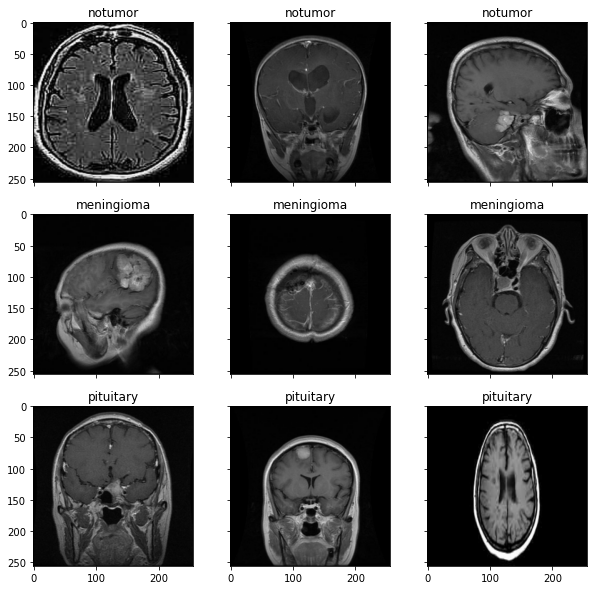

In [11]:
# Visualize the dataset with labels.
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_dataset.take(1):
    for i in range(3):
         for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].title.set_text(train_dataset.class_names[labels[i*3].numpy().argmax()])
plt.show()

In [12]:

test_dataset = create_dataset(test_path, img_size=(256, 256), batch_size=BATCH_SIZE, shuffle=False)

Found 1311 files belonging to 4 classes.


In [13]:
# Dataset labels.
test_dataset.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [14]:
# Create a DataFrame with the count of each label in the test dataset.
test_labels_df = label_count_df(test_dataset)

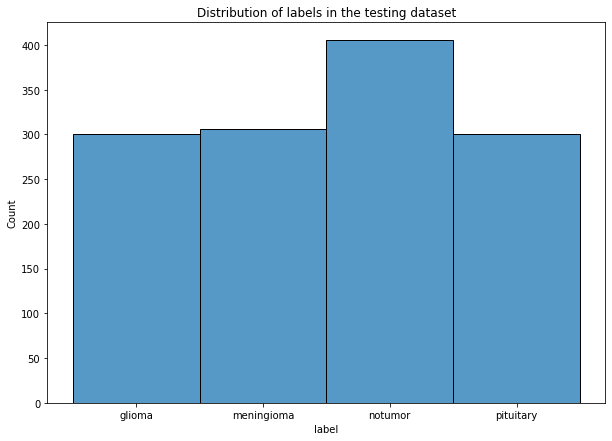

In [16]:
# Plot the count of each label in the dataset.
plt.figure(figsize=(10, 7))
sns.histplot(test_labels_df.label).set_title("Distribution of labels in the testing dataset");

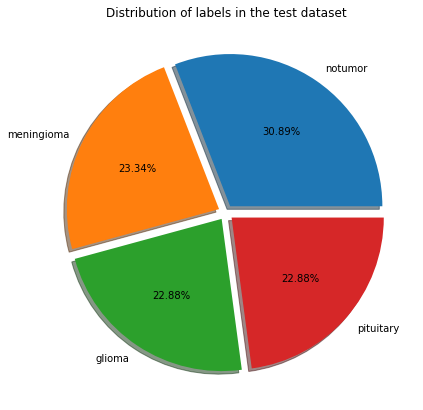

In [17]:
# Pie Chart for the distribution of labels in the training dataset.
plt.figure(figsize=(10, 7))
plt.title("Distribution of labels in the test dataset")
plt.pie(test_labels_df.label.value_counts(), 
        labels=test_labels_df.label.value_counts().index, 
        autopct='%1.2f%%', 
        shadow=True, 
        explode=[0.05, 0.05, 0.05, 0.05])
plt.show()

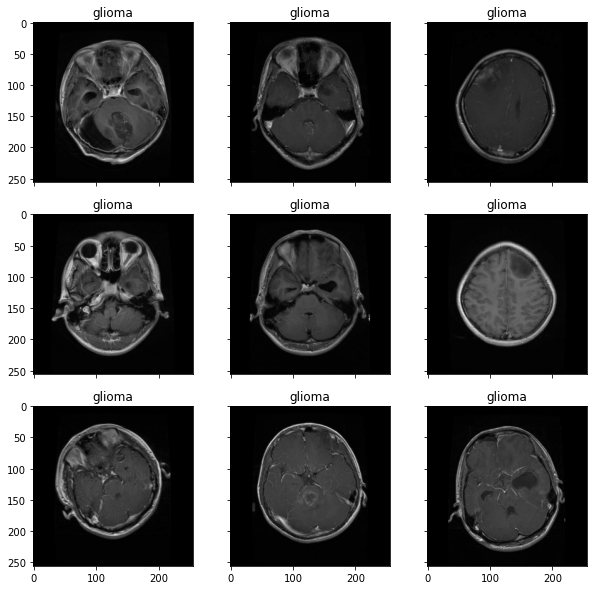

In [18]:
# Visualize the dataset with labels.
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in test_dataset.take(1):
    for i in range(3):
         for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].title.set_text(test_dataset.class_names[labels[i*3].numpy().argmax()])
plt.show()

DATA AUGMENTATION

In [19]:
# Function to augment the dataset.

def normalize_dataset(dataset, normalisation_range="01"):
    """
    Function to normalize the dataset.
    """
    if normalisation_range == "01":
        norm_layer = layers.Rescaling(1./255)
    elif normalisation_range == "-11":
        norm_layer = layers.Rescaling(1./127.5, offset= -1)
    else:
        raise ValueError("normalisation_range can only be 01 or -11")
    normalisation = Sequential([norm_layer])
    normalised_dataset = dataset.map(
        lambda x, y: (normalisation(x,training = True), y)
    )
    return normalised_dataset

def normalise_augment_dataset(dataset, normalisation_range="01", input_shape=(256, 256, 3)):
    """
    Function to augment the dataset.
    """
    if normalisation_range == "01":
        normalisation_layer = layers.Rescaling(1./255)
    elif normalisation_range == "-11":
        normalisation_layer = layers.Rescaling(1./127.5, offset= -1)
    else:
        raise ValueError("normalisation_range can only be 01 or -11")
    data_augmentation = Sequential(
        [
            layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
            layers.RandomRotation(0.2),
            layers.RandomBrightness(0.2),
            layers.RandomContrast(0.2),
            layers.RandomZoom(0.2),
            normalisation_layer,
        ]
    )
    augmented_dataset = dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y)
    )
    return augmented_dataset

In [20]:
# Augment the dataset.

train_dataset = normalise_augment_dataset(train_dataset, normalisation_range="01", input_shape=(256, 256, 3))
valid_dataset = normalise_augment_dataset(valid_dataset, normalisation_range="01", input_shape=(256, 256, 3))
test_dataset  = normalize_dataset(test_dataset, normalisation_range="01")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
# Optimise The datasets.
# prefetching overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset  = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

### TRAINING MODEL

#### CNN MODEL


In [22]:
epochs = 30

In [23]:
# CallBacks
my_callbacks = [
                EarlyStopping(monitor="loss", patience=7, restore_best_weights=True),
                ]

In [24]:
# CNN Model 

model = Sequential([

    InputLayer(input_shape=(256, 256, 3)),
    Conv2D(filters = 8, kernel_size = (3,3), padding = "same", kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 16, kernel_size = (3,3), padding = "same", kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 32, kernel_size = (3,3), padding = "same", kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 64, kernel_size = (3,3), padding = "same", kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 128, kernel_size = (3,3), padding = "same", kernel_regularizer = tf.keras.regularizers.L2(0.01), activation = tf.nn.relu),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),

    Flatten(),
    Dense(512,kernel_regularizer = tf.keras.regularizers.L2(0.01), activation="relu"),
    Dropout(0.3),
    Dense(256,kernel_regularizer = tf.keras.regularizers.L2(0.01), activation="relu"),
    Dropout(0.2),
    Dense(128,kernel_regularizer = tf.keras.regularizers.L2(0.01), activation="relu"),
    Dropout(0.1),
    Dense(4, activation = "softmax"),
])

In [25]:
# Compile the model.

model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 8)      32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      1168      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                      

In [27]:
# Train the model.

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks = my_callbacks)

Epoch 1/30
286/286 [==============================] - 176s 604ms/step - loss: 10.6996 - accuracy: 0.4801 - val_loss: 6.5053 - val_accuracy: 0.2285
Epoch 2/30
286/286 [==============================] - 139s 484ms/step - loss: 4.0336 - accuracy: 0.5716 - val_loss: 3.3900 - val_accuracy: 0.4317
Epoch 3/30
286/286 [==============================] - 136s 475ms/step - loss: 2.6027 - accuracy: 0.6241 - val_loss: 2.3050 - val_accuracy: 0.5911
Epoch 4/30
286/286 [==============================] - 152s 532ms/step - loss: 1.9763 - accuracy: 0.6674 - val_loss: 2.2642 - val_accuracy: 0.5254
Epoch 5/30
286/286 [==============================] - 146s 512ms/step - loss: 1.6225 - accuracy: 0.7123 - val_loss: 1.5803 - val_accuracy: 0.7040
Epoch 6/30
286/286 [==============================] - 143s 501ms/step - loss: 1.4573 - accuracy: 0.7492 - val_loss: 1.8834 - val_accuracy: 0.5902
Epoch 7/30
286/286 [==============================] - 140s 489ms/step - loss: 1.3191 - accuracy: 0.7777 - val_loss: 1.5827 

In [31]:
# Save the model.

model.save("Models/basic_model.h5")

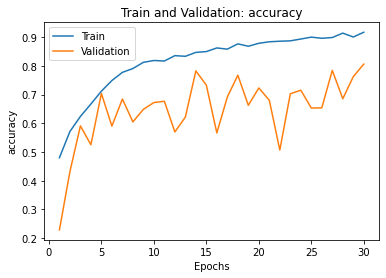

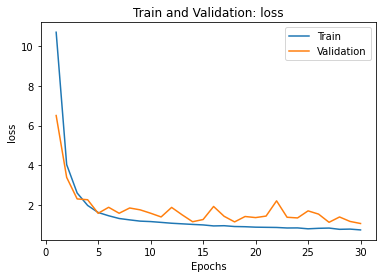

In [28]:
# Plotting Accuracy.
plot_metric(history, "accuracy")

# Plotting Losses.
plot_metric(history, "loss")

In [29]:
# Model evaluation uing test dataset.
model.evaluate(test_dataset)


82/82 [==============================] - 13s 158ms/step - loss: 0.9788 - accuracy: 0.8444


[0.9788164496421814, 0.8443936109542847]

In [32]:
model_trained = load_model("Models/basic_model.h5")

In [33]:
# Predictions on the test dataset.

test_predictions_labels = model_trained.predict(test_dataset).argmax(axis=1)

82/82 [==============================] - 13s 149ms/step


In [34]:
# true labels

test_true_labels = test_labels_df["label"].map({"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3})
test_true_labels = np.asarray(test_true_labels)

In [35]:
classif_report = classification_report(test_true_labels, test_predictions_labels, target_names=CLASS_NAMES, zero_division="warn")
print(classif_report)

              precision    recall  f1-score   support

      glioma       0.92      0.82      0.86       300
  meningioma       0.80      0.68      0.73       306
     notumor       0.95      0.89      0.92       405
   pituitary       0.73      0.98      0.83       300

    accuracy                           0.84      1311
   macro avg       0.85      0.84      0.84      1311
weighted avg       0.86      0.84      0.84      1311



<Figure size 720x720 with 0 Axes>

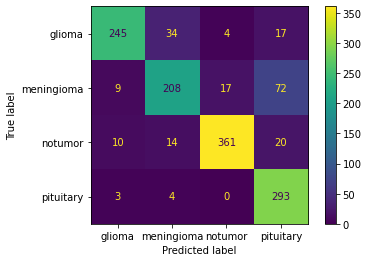

In [36]:
# Confusion Matrix
confu_matrix = confusion_matrix(test_true_labels, test_predictions_labels)
confu_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=confu_matrix, display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10))
confu_matrix_disp.plot();
plt.show();

### Transfer Learning

#### Xception Model

##### Preparing the datasets for "Xception" Model

In [20]:
epochs = 20

In [21]:
# CallBacks

my_callbacks = [
                EarlyStopping(monitor="loss", patience=7, restore_best_weights=True),
                ]

In [22]:
# Creating new train and validation datasets with image size 299x299.
train_dataset, valid_dataset = create_train_val_ds(train_path, img_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


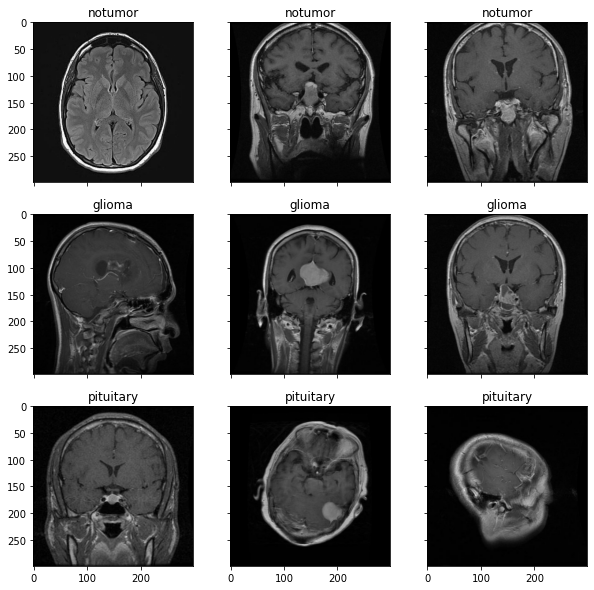

In [23]:
# Plotting some images from the train dataset. 

fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_dataset.take(1):
    for i in range(3):
         for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].title.set_text(train_dataset.class_names[labels[i*3].numpy().argmax()])
plt.show()

In [24]:
test_dataset = create_dataset(test_path, img_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 1311 files belonging to 4 classes.


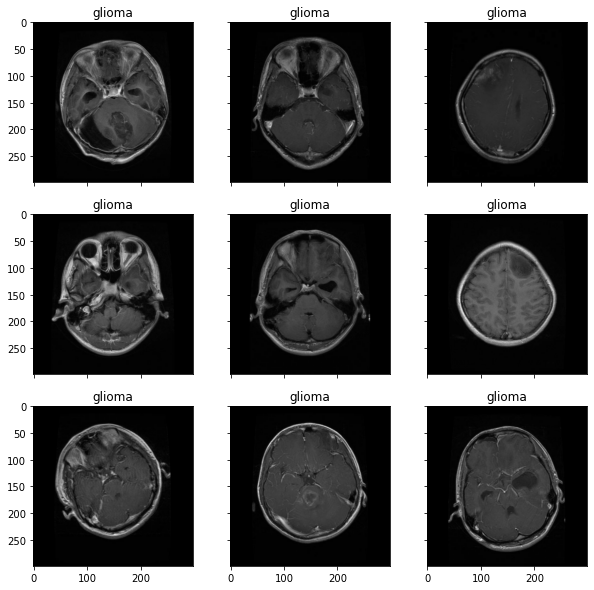

In [25]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in test_dataset.take(1):
    for i in range(3):
         for j in range(3):
            ax[i][j].imshow(images[i*3+j].numpy().astype("uint8"))
            ax[i][j].title.set_text(test_dataset.class_names[labels[i*3].numpy().argmax()])
plt.show()

In [26]:
# Augmenting the datasets.

train_dataset = normalise_augment_dataset(train_dataset, normalisation_range="-11", input_shape=(299, 299, 3))
valid_dataset = normalise_augment_dataset(valid_dataset, normalisation_range="-11", input_shape=(299, 299, 3))
test_dataset  = normalize_dataset(test_dataset, normalisation_range="-11")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [27]:
# Optimise The datasets.
AUTOTUNE = tf.data.AUTOTUNE
train_dataset  = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
# pretrained_model = keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),include_top=True, weights='imagenet')

# pretrained_model.trainable = False

96112376/96112376 [==============================] - 9s 0us/step


In [28]:
# load the pretrained model.
pretrained_model = tf.keras.applications.Xception(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

# Freeze the pretrained model
pretrained_model.trainable = False

In [29]:
transfer_model = Sequential([
    pretrained_model, 
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(256, activation="relu"),
    Dropout(0.25),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(4, activation="softmax")
])

In [30]:
transfer_model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

In [31]:
transfer_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [32]:
transfer_history = transfer_model.fit(train_dataset, validation_data=valid_dataset, epochs=epochs, callbacks = my_callbacks)

Epoch 1/20
286/286 [==============================] - 788s 3s/step - loss: 0.7644 - accuracy: 0.6908 - val_loss: 0.5591 - val_accuracy: 0.7680
Epoch 2/20
286/286 [==============================] - 759s 3s/step - loss: 0.5073 - accuracy: 0.8053 - val_loss: 0.5207 - val_accuracy: 0.8135
Epoch 3/20
286/286 [==============================] - 747s 3s/step - loss: 0.4336 - accuracy: 0.8389 - val_loss: 0.4130 - val_accuracy: 0.8336
Epoch 4/20
286/286 [==============================] - 754s 3s/step - loss: 0.3979 - accuracy: 0.8519 - val_loss: 0.4317 - val_accuracy: 0.8599
Epoch 5/20
286/286 [==============================] - 755s 3s/step - loss: 0.3784 - accuracy: 0.8635 - val_loss: 0.4254 - val_accuracy: 0.8520
Epoch 6/20
286/286 [==============================] - 826s 3s/step - loss: 0.3428 - accuracy: 0.8735 - val_loss: 0.4186 - val_accuracy: 0.8573
Epoch 7/20
286/286 [==============================] - 818s 3s/step - loss: 0.3188 - accuracy: 0.8829 - val_loss: 0.4114 - val_accuracy: 0.8546

In [35]:
transfer_model.save("Models/Xception_model.h5")

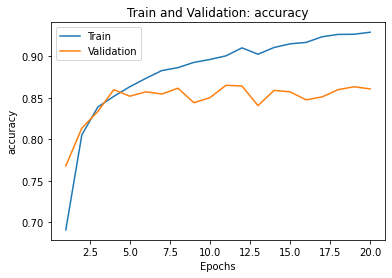

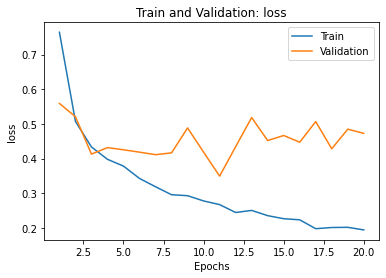

In [33]:
# Plotting Accuracy.
plot_metric(transfer_history, "accuracy")

# Plotting Losses.
plot_metric(transfer_history, "loss")

In [34]:
transfer_model.evaluate(test_dataset)

82/82 [==============================] - 173s 2s/step - loss: 0.4840 - accuracy: 0.8619


[0.4839963912963867, 0.8619374632835388]

In [36]:
model_trained = load_model("Models/Xception_model.h5")

In [37]:
# Predicting the labels of the test dataset.

test_predictions_labels = model_trained.predict(test_dataset).argmax(axis=1)

82/82 [==============================] - 173s 2s/step


In [38]:
test_true_labels = test_labels_df["label"].map({"glioma": 0, "meningioma": 1, "notumor": 2, "pituitary": 3})
test_true_labels = np.asarray(test_true_labels)

In [39]:
classif_report = classification_report(test_true_labels, test_predictions_labels, target_names=CLASS_NAMES, zero_division="warn")
print(classif_report)

              precision    recall  f1-score   support

      glioma       0.87      0.89      0.88       300
  meningioma       0.83      0.58      0.69       306
     notumor       0.86      0.98      0.92       405
   pituitary       0.89      0.95      0.92       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.85      1311



<Figure size 720x720 with 0 Axes>

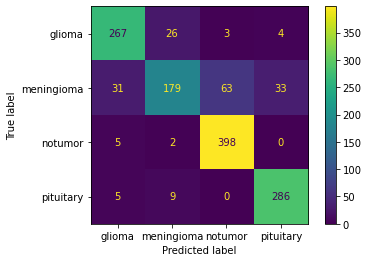

In [40]:
# Confusion Matrix
confu_matrix = confusion_matrix(test_true_labels, test_predictions_labels)
confu_matrix_disp = ConfusionMatrixDisplay(confusion_matrix=confu_matrix, display_labels=CLASS_NAMES)
plt.figure(figsize=(10,10))
confu_matrix_disp.plot();
plt.show();
